# Introduction

In today's competitive hospitality industry, understanding and improving guest satisfaction is critical for hosts, property managers, and platform administrators to maintain high occupancy rates and positive reviews.

Airbnb, as one of the leading platforms in the short-term rental market, provides a wealth of data through guest reviews. This project will implemented RoBERTa from HuggingFace’s Transformers library for sentiment analysis from review data.

The primary objective of this project is to develop a sentiment analysis pipeline capable of measuring guest satisfaction over time by analyzing sentiment from Airbnb reviews. This system will enable hosts and property managers to track changes in guest satisfaction, evaluate the effectiveness of improvements or changes made to their properties or services, and make data-driven decision-making to enhance guest experiences.



# Setup

## Load Essential Libraries

In [ ]:
# Import neccessary libraries

import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Dataset

### Download Dataset

In [ ]:
# Download data
import requests
request = requests.get("https://drive.google.com/uc?export=download&id=1wHt8PsMLsfX5yNSqrt2fSTcb8LEiclcf")
with open("data.zip", "wb") as file:
    file.write(request.content)

# Unzip data
import zipfile
with zipfile.ZipFile('data.zip') as zip:
    zip.extractall('data')

### Data Loading and Inspection

In [ ]:
# Data loading
df = pd.read_csv('data/reviews.csv')

# Display data
df.head()

Data Inspection

In [ ]:
# Check the shape of data
print(df.shape)

(503626, 6)


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503626 entries, 0 to 503625
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     503626 non-null  int64 
 1   id             503626 non-null  int64 
 2   date           503626 non-null  object
 3   reviewer_id    503626 non-null  int64 
 4   reviewer_name  503625 non-null  object
 5   comments       503528 non-null  object
dtypes: int64(3), object(3)
memory usage: 23.1+ MB
None


In [ ]:
# Check for missing values
print(df.isnull().sum())

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     1
comments         98
dtype: int64


Handling Missing Values

In [ ]:
# Drop rows with missing values
df.dropna(subset=['comments'], inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

## Data Preparation

Clean review text by removing unnecessary characters, HTML tags, URLs, and special symbols.

In [ ]:
def clean_text(text):
    # Remove HTML tags as they might confuse the model.
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs as they might not provide valuable sentiment information
    text = re.sub(r'http\S+|www.\S+', '', text)

    return text

# Apply cleaning function to the review text column
df['cleaned_comments'] = df['comments'].apply(clean_text)

# Display 5 samples from the test data
print(df[['comments', 'cleaned_comments']].sample(5))

                                            comments  \
0  Great home away from home! Bridgette and Marth...   
1  Das Cottage liegt ruhig und sicher.  Wir haben...   
2  This cottage was a great base from which to ex...   
3  I had a great stay.  All my needs were well ex...   
4  Excellent host. She provided everything we cou...   

                                    cleaned_comments  
0  Great home away from home! Bridgette and Marth...  
1  Das Cottage liegt ruhig und sicher.  Wir haben...  
2  This cottage was a great base from which to ex...  
3  I had a great stay.  All my needs were well ex...  
4  Excellent host. She provided everything we cou...  


Detect and Remove Non-English Reviews

In [ ]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# Set seed for reproducibility in language detection: Ensuring Consistent Results
DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        # If language detection fails, assume it's not English
        return 'unknown'

Apply Language Detection

In [ ]:
# Add a new column for detected language
df['language'] = df['cleaned_comments'].apply(detect_language)

# Display the language distribution
print(df['language'].value_counts())

language
en         457197
de          19279
fr           7606
nl           3388
ro           2118
pt           2086
unknown      1436
af           1319
es           1258
it            906
ca            796
ar            735
so            542
tl            536
ru            495
no            488
sv            450
cs            320
sw            264
hr            260
da            236
zh-cn         234
hu            201
ko            185
cy            178
id            149
he            142
fi            139
pl            112
tr             87
vi             73
et             70
ja             62
sl             43
sk             41
zh-tw          22
fa             19
ur             17
sq             10
uk              9
bg              7
lt              5
th              2
hi              2
el              2
lv              2
Name: count, dtype: int64


Filter Out Non-English Reviews

In [ ]:
# Filter out non-English reviews
df_english = df[df['language'] == 'en']

# Reset index after filtering
df_english.reset_index(drop=True, inplace=True)

# Check the shape of the filtered dataset
print("Original dataset size:", df.shape)
print("Filtered dataset size:", df_english.shape)

Original dataset size: (503528, 8)
Filtered dataset size: (457197, 8)


# RoBERTa Model

In [ ]:
# Import neccessary libraries

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# import cleaned data
reviews_df = pd.read_csv('airbnb_reviews_english.csv')

In [ ]:
# Imput Airbnb listing ID
listing_id = 15007

# Filter the DataFrame for the specified listing_id
filtered_reviews = df_english[df_english['listing_id'] == listing_id]
print(filtered_reviews['listing_id'].value_counts())

listing_id
15007    43
Name: count, dtype: int64


In [ ]:
example = filtered_reviews['cleaned_comments'].iloc[2]
print(example)

The location of this lovey holiday home is 25mins from the city centre and in a beautiful quiet area next to the beach. It was easy to find as it is directly across from a lovely restaurant called 'Ons Huisie'. The place itself is a fantastic holiday home, spacious and extremely clean. It's the perfect place to have a braai on the stoep watching the sun go down with a glass of wine. We felt safe throughout the duration of our stay which made it the relaxing break we hoped it would be.Dirk and his mother, Ritha were a pleasure to deal with. We met Ritha on the first day who was more than understanding about our hour delay due to peak hour traffic. She was very thorough in explaining everything that we needed to know. Dirk was just as helpful when we checked out, as well as keeping in contact before and during our stay.The kitchen was stocked with all necessities as well as 2 lovely bottles of local wine.For the price of this holiday home it's an absolute steal. Highly recommended-we wil

In [ ]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.00248178, 'roberta_neu': 0.016876731, 'roberta_pos': 0.9806414}


In [ ]:
from tqdm import tqdm

def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
  }
  return scores_dict

In [ ]:
results = {}
for i, row in tqdm(df_english.iterrows(), total=len(df_english)):
  try:
    text = row['cleaned_comments']
    myid = row['id']

    # RoBERTa Sentiment Analysis
    roberta_result = polarity_scores_roberta(text)

    # Storing Results
    results[myid] = roberta_result
  except RuntimeError:
    print(f'Broke for id {myid}')

100%|██████████| 43/43 [00:12<00:00,  3.56it/s]


In [ ]:
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = filtered_reviews.merge(results_df, how='left')

In [ ]:
results_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,cleaned_comments,language,roberta_neg,roberta_neu,roberta_pos
0,15007,9223897,2013-12-15,7175290,Morne,We spent a fantastic two week holiday at the B...,We spent a fantastic two week holiday at the B...,en,0.001560,0.007618,0.990822
1,15007,53759983,2015-11-12,13937367,Ciske,Fabulous house in a stunning location! The lov...,Fabulous house in a stunning location! The lov...,en,0.001499,0.006461,0.992040
2,15007,55131160,2015-11-28,28986066,Samantha,The location of this lovey holiday home is 25m...,The location of this lovey holiday home is 25m...,en,0.002482,0.016877,0.980641
3,15007,60945736,2016-01-30,6769287,Thomas,Communication & response very fast and reliabl...,Communication & response very fast and reliabl...,en,0.001964,0.016023,0.982013
4,15007,61787988,2016-02-08,53613595,Inés,The location of the house was great!!! the hou...,The location of the house was great!!! the hou...,en,0.001800,0.006414,0.991786


# Results

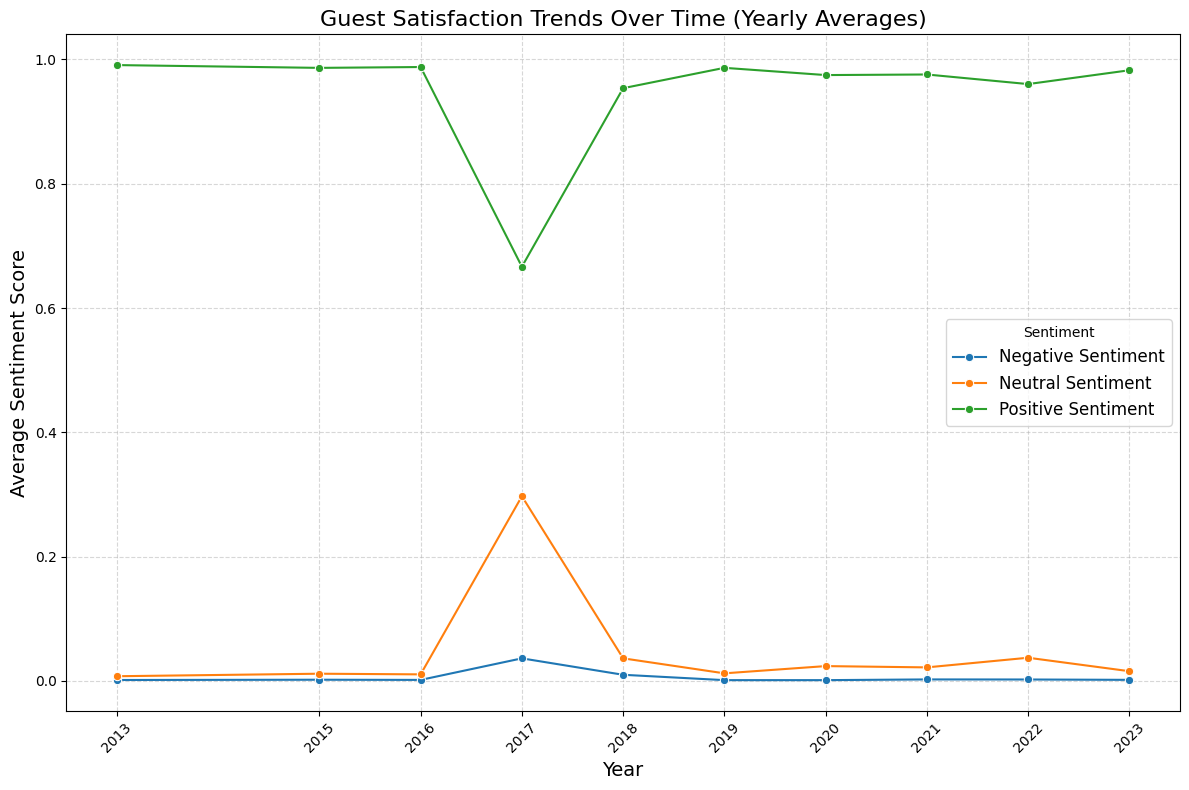

In [ ]:
# Visualize guest satisfaction trends

# Convert 'date' column to datetime objects if it's not already
results_df['date'] = pd.to_datetime(results_df['date'])

# Group by year and calculate the mean sentiment scores
yearly_sentiment = results_df.groupby(results_df['date'].dt.year)[['roberta_neg', 'roberta_neu', 'roberta_pos']].mean()

plt.figure(figsize=(12, 8))

# Plot negative sentiment
sns.lineplot(x=yearly_sentiment.index, y=yearly_sentiment['roberta_neg'], label='Negative Sentiment', marker='o')

# Plot neutral sentiment
sns.lineplot(x=yearly_sentiment.index, y=yearly_sentiment['roberta_neu'], label='Neutral Sentiment', marker='o')

# Plot positive sentiment
sns.lineplot(x=yearly_sentiment.index, y=yearly_sentiment['roberta_pos'], label='Positive Sentiment', marker='o')

plt.title('Guest Satisfaction Trends Over Time (Yearly Averages)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.xticks(yearly_sentiment.index, rotation=45)  # Show all years on x-axis and rotate for readability
plt.legend(title='Sentiment', fontsize=12) # Add legend title
plt.grid(True, linestyle='--', alpha=0.5) # Add grid for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

## Overall Interpretation
- The year 2017 appears to be a critical point where there was a significant shift in guest satisfaction.
- After 2017, there is a recovery in positive sentiment and a decrease in both neutral and negative sentiments, suggesting that measures were taken to improve guest satisfaction, and these efforts were successful.
- The overall trend indicates that while there was a temporary decline in guest satisfaction, the organization managed to recover and maintain a high level of positive sentiment in subsequent years